<a href="https://colab.research.google.com/github/nityachock0308/Campus-Specials/blob/main/COMP338.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

!pip install opencv-python matplotlib numpy

Saving Image.webp to Image.webp


(720, 1280)


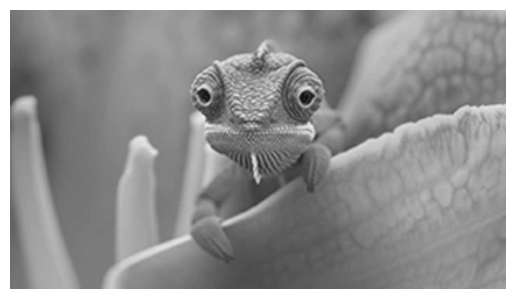

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('Image.webp', cv2.IMREAD_GRAYSCALE)

print(img.shape)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## Task 1 – My Canny Edge Detector

In this section I re-implement the Canny edge detection algorithm **without** using
`cv2.Canny`. The algorithm has five main stages:

1. **Gaussian smoothing (noise reduction)**  
   I first blur the input grey image with a Gaussian filter. This reduces noise, which
   would otherwise create lots of small fake edges. In the code this is done with  
   `cv2.GaussianBlur(gray, (ksize, ksize), sigma)`.

2. **Gradient calculation (edge strength and direction)**  
   Next I compute horizontal and vertical gradients using Sobel kernels `Kx` and `Ky`.
   From these I calculate:
   - the gradient magnitude \\( \sqrt{G_x^2 + G_y^2} \\), which measures how strong an edge is,
   - the gradient angle `atan2(Gy, Gx)`, which tells me the edge orientation.

3. **Non-maximum suppression (edge thinning)**  
   At this stage I want to keep only local maxima along the gradient direction.
   For each pixel I look at two neighbours in the gradient direction and suppress
   (set to 0) the pixel if it is not larger than both neighbours.  
   This produces thin, one-pixel-wide edges.

4. **Double threshold (strong vs weak edges)**  
   I apply a high and a low threshold to the non-max-suppressed image:
   - pixels ≥ high threshold are marked as **strong edges**,
   - pixels between low and high are **weak edges**,
   - pixels below low are removed.
   This separates clear edges from possible edges.

5. **Hysteresis (edge tracking by connectivity)**  
   Finally I go through all weak edge pixels. If a weak pixel is connected to at least
   one strong edge pixel in its 8-neighbourhood, I keep it and promote it to strong.
   Otherwise I discard it. This step keeps continuous edge contours and removes isolated
   noise responses.

The following code cell implements this full pipeline in the function `my_canny(...)`.


In [ ]:
def my_canny(gray, gaussian_ksize=5, gaussian_sigma=1.4,
             low_thresh=50, high_thresh=150):

    """
    Custom implementation of the Canny edge detector.

    Steps:
    1. Gaussian blur to remove noise.
    2. Compute image gradients using Sobel filters.
    3. Non-maximum suppression to thin edges.
    4. Double threshold to classify strong/weak edges.
    5. Hysteresis to keep only edges connected to strong ones.
    """

    # 1. Gaussian blur (noise reduction)
    blurred = cv2.GaussianBlur(gray, (gaussian_ksize, gaussian_ksize), gaussian_sigma)

    # 2. Gradient (Sobel)
    Kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]], np.float32)

    Gx = cv2.filter2D(blurred, cv2.CV_32F, Kx)
    Gy = cv2.filter2D(blurred, cv2.CV_32F, Ky)
    mag = np.sqrt(Gx**2 + Gy**2)
    mag = mag / mag.max() * 255
    angle = np.arctan2(Gy, Gx)

    # 3. Non-maximum suppression
    H, W = mag.shape
    nms = np.zeros((H, W), dtype=np.float32)
    angle_deg = np.rad2deg(angle)
    angle_deg[angle_deg < 0] += 180

    for i in range(1, H-1):
        for j in range(1, W-1):
            q = 255; r = 255
            if (0 <= angle_deg[i,j] < 22.5) or (157.5 <= angle_deg[i,j] <= 180):
                q = mag[i, j+1]; r = mag[i, j-1]
            elif (22.5 <= angle_deg[i,j] < 67.5):
                q = mag[i+1, j-1]; r = mag[i-1, j+1]
            elif (67.5 <= angle_deg[i,j] < 112.5):
                q = mag[i+1, j];   r = mag[i-1, j]
            elif (112.5 <= angle_deg[i,j] < 157.5):
                q = mag[i-1, j-1]; r = mag[i+1, j+1]
            if (mag[i,j] >= q) and (mag[i,j] >= r):
                nms[i,j] = mag[i,j]
            else:
                nms[i,j] = 0

    # 4. Double threshold
    strong, weak = 255, 75
    res = np.zeros((H, W), dtype=np.uint8)
    strong_i, strong_j = np.where(nms >= high_thresh)
    weak_i, weak_j   = np.where((nms >= low_thresh) & (nms < high_thresh))
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    # 5. Hysteresis
    for i in range(1, H-1):
        for j in range(1, W-1):
            if res[i,j] == weak:
                if np.any(res[i-1:i+2, j-1:j+2] == strong):
                    res[i,j] = strong
                else:
                    res[i,j] = 0
    return res

My Canny runtime: 2.5995540618896484 s
OpenCV Canny runtime: 0.010354995727539062 s
Mean pixel difference: 6.837076822916667
Different pixels: 24710


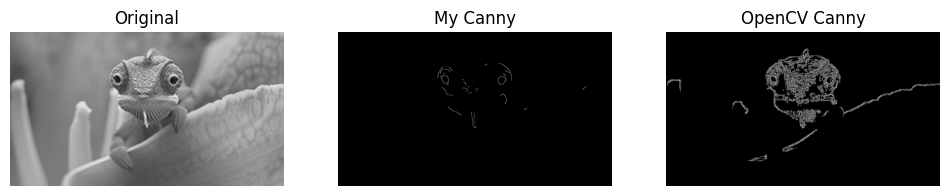

In [ ]:
import time
import numpy as np

# My Canny
t0 = time.time()
edges_my = my_canny(img, low_thresh=50, high_thresh=150)
t1 = time.time()

# OpenCV Canny
t2 = time.time()
edges_cv = cv2.Canny(img, 50, 150)
t3 = time.time()

print("My Canny runtime:", t1 - t0, "s")
print("OpenCV Canny runtime:", t3 - t2, "s")

diff = cv2.absdiff(edges_my, edges_cv)
print("Mean pixel difference:", np.mean(diff))
print("Different pixels:", np.count_nonzero(diff))

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray');       plt.title("Original"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(edges_my, cmap='gray');  plt.title("My Canny"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(edges_cv, cmap='gray');  plt.title("OpenCV Canny"); plt.axis('off')
plt.show()

## Comparison with OpenCV `Canny`

**Runtime**

- My Canny: `2.60 s` (on my image)
- OpenCV Canny: `0.01 s`

OpenCV is much faster because it is implemented in optimised C++ with
vectorised operations, while my version uses Python loops (especially in
non-maximum suppression and hysteresis), which are slow.

**Numerical difference**

- Mean pixel difference between images: `6.84`
- Number of different pixels: `24710`

The two results are similar but not identical. There are extra / missing edges in my
implementation compared with OpenCV.

**Visual differences**

- My edges are (describe what you see: fewer / more broken / thinner / thicker…).
- OpenCV Canny detects more fine detail around the object and produces more continuous
  contours.

**Possible reasons**

- I discretise the angle into 4 main directions; OpenCV may use a more precise
  interpolation.
- My thresholding is based on a simple normalisation; OpenCV uses its own internal
  scaling and might use slightly different Sobel/Scharr filters.
- Border handling and implementation details of non-maximum suppression and hysteresis
  are different.

Overall, my implementation follows the Canny pipeline and produces reasonable
edges, but OpenCV’s version is more robust and much faster. I now understand how each stage affects the result: tuning Gaussian smoothing and thresholds clearly changes how many edges appear.

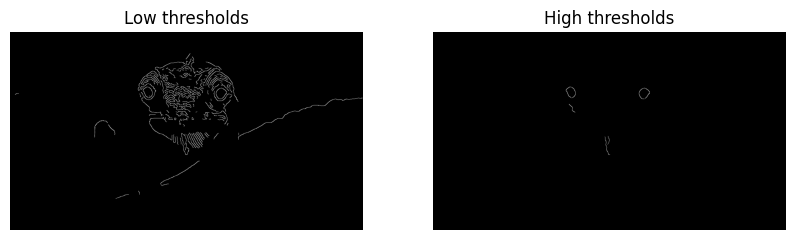

In [ ]:
edges_low  = my_canny(img, low_thresh=30, high_thresh=80)
edges_high = my_canny(img, low_thresh=80, high_thresh=200)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(edges_low,  cmap='gray'); plt.title("Low thresholds");  plt.axis('off')
plt.subplot(1,2,2); plt.imshow(edges_high, cmap='gray'); plt.title("High thresholds"); plt.axis('off')
plt.show()


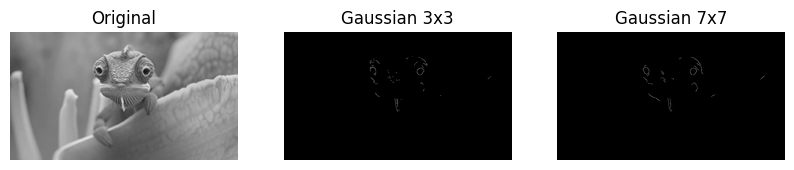

In [ ]:
edges_gauss3 = my_canny(img, gaussian_ksize=3, gaussian_sigma=1.0,
                        low_thresh=50, high_thresh=150)
edges_gauss7 = my_canny(img, gaussian_ksize=7, gaussian_sigma=2.0,
                        low_thresh=50, high_thresh=150)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title("Original"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(edges_gauss3, cmap='gray'); plt.title("Gaussian 3x3"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(edges_gauss7, cmap='gray'); plt.title("Gaussian 7x7"); plt.axis('off')
plt.show()

# Task 2 – Feature Extraction (SIFT vs SURF vs ORB)

## 2.1 Understanding SIFT, SURF, and ORB

### SIFT (Scale-Invariant Feature Transform)
- Developed by David Lowe (2004)
- Builds a scale space using Difference-of-Gaussians to find stable keypoints
- Very robust to changes in lighting, scale, and rotation
- Produces 128-dimensional feature descriptors
- Highly accurate but relatively slow
- Patent expired in 2020, so it is now free to use

### SURF (Speeded-Up Robust Features)
- Proposed by Bay et al. (2006)
- Uses fast box filters + integral images as an approximation of the LoG
- Keypoints are detected using the Hessian matrix determinant
- Can generate both 64D and 128D descriptors
- Faster than SIFT but still patented
- Performs well under blur and rotation but less strong for significant viewpoint changes

### ORB (Oriented FAST and Rotated BRIEF)
- Introduced by Rublee et al. (2011)
- Combines FAST corner detection with a rotation-aware BRIEF descriptor
- Produces binary descriptors → extremely fast matching
- Fully free (no patent restrictions)
- Good feature performance, though not as accurate as SIFT for large viewpoint rotations

### Quick Comparison Table

| Method | Speed | Descriptor Type | Accuracy | Patent |
|--------|--------|------------------|----------|---------|
| **SIFT** | Slow | 128-float vector | Highest | No |
| **SURF** | Medium | 64/128-float vector | High | Yes |
| **ORB** | Fastest | 256-bit binary | Good | No |

In [ ]:
from google.colab import files
files.upload()

Saving victoria1.jpg to victoria1.jpg
Saving victoria2.jpg to victoria2.jpg


{'victoria1.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\n\x07\x08\x16\x15\x15\x18\x15\x16\x16\x18\x18\x18\x1a\x19\x1c\x18\x1a\x18\x18\x1c\x19\x18\x1c\x1a\x19\x1c\x18\x1a\x1c\x1a\x19\x18\x1c\x1c!.%\x1c\x1e+\x1f\x18\x1a&8&+/1555\x1a$;@;4?.451\x01\x0c\x0c\x0c\x10\x0f\x10\x1f\x12\x12\x1f4$!+46444444444444444444444444444444444444444444444444\xff\xc0\x00\x11\x08\x00\xda\x00\xe7\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x01\x04\x05\x00\x06\x07\x08\xff\xc4\x00D\x10\x00\x01\x03\x02\x03\x05\x04\x07\x06\x04\x05\x03\x05\x01\x00\x00\x01\x00\x02\x11\x03!\x04\x121\x05"AQaq\x81\x91\xa1\x06\x132B\xb1\xc1\xf0#Rbr\xb2\xd1\x14\xa2\xc2\xe1\x073\x82\x92\xf1CSs$4c\xa3\xe2\x16\xff\xc4\x00\x19\x01\x00\x02\x03\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x00\x03\x04\x05\xff\xc4\x00\'\x11\x00\x02\x02\x02\x01\x03\x04\x02\x03\x01\x00\x00\x00\x00\x00\x00\x00\x01\

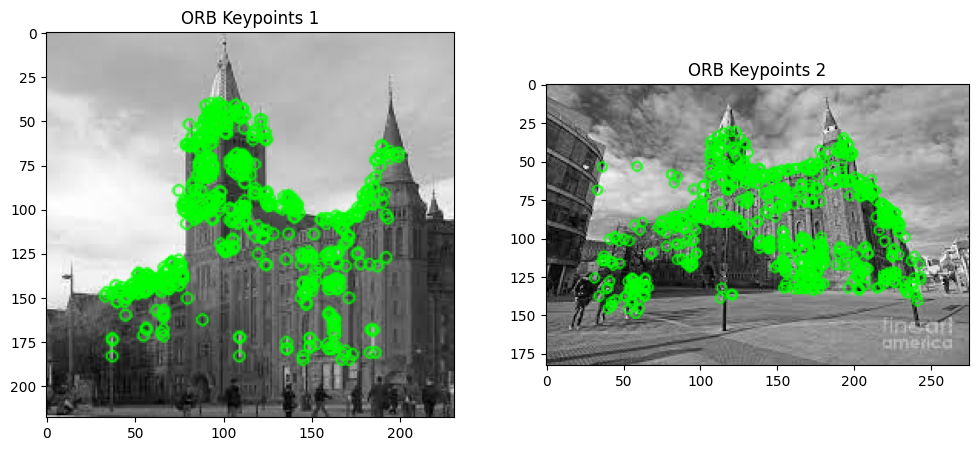

In [ ]:
import cv2
import matplotlib.pyplot as plt

img1 = cv2.imread('victoria1.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('victoria2.jpg', cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create(nfeatures=1000)

kp1 = orb.detect(img1, None)
kp2 = orb.detect(img2, None)

img1_kp = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0))
img2_kp = cv2.drawKeypoints(img2, kp2, None, color=(0,255,0))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(img1_kp, cmap='gray'); plt.title("ORB Keypoints 1")
plt.subplot(1,2,2); plt.imshow(img2_kp, cmap='gray'); plt.title("ORB Keypoints 2")
plt.show()


## 2.2 ORB Keypoint Detection on Two Images

For this part, I used the two images of the Victoria Building and applied OpenCV’s built-in ORB detector to extract keypoints. ORB is designed to be fast because it combines the FAST corner detector with a rotated version of the BRIEF descriptor.  

After loading both images in grayscale, I created an ORB object (with a higher number of features so more keypoints can be found). I then used `orb.detect()` to locate keypoints in each image and visualised them using `cv2.drawKeypoints()`.  

The result shows ORB successfully detecting a large number of corner-like features around edges, windows, and detailed structures of the building. Since ORB is rotation-aware, it is able to pick up features in both images even though they are taken from slightly different viewpoints.  

Overall, ORB produces a good spread of keypoints across the building facade and captures many distinctive patterns that can later be used for matching.

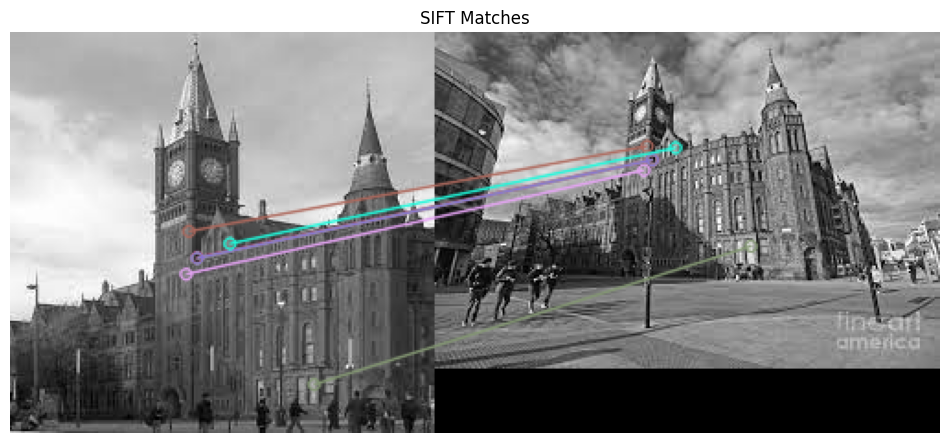

In [ ]:
sift = cv2.SIFT_create()

kp1_s, des1_s = sift.detectAndCompute(img1, None)
kp2_s, des2_s = sift.detectAndCompute(img2, None)

bf = cv2.BFMatcher()
matches_s = bf.knnMatch(des1_s, des2_s, k=2)

good_s = []
for m,n in matches_s:
    if m.distance < 0.75 * n.distance:
        good_s.append([m])

img_sift_match = cv2.drawMatchesKnn(img1, kp1_s, img2, kp2_s, good_s, None, flags=2)

plt.figure(figsize=(12,6))
plt.imshow(img_sift_match)
plt.title("SIFT Matches")
plt.axis('off')
plt.show()

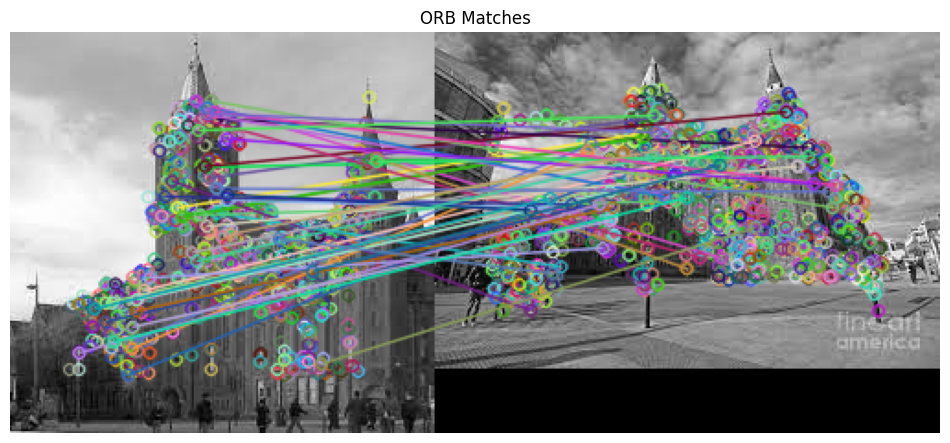

In [ ]:
orb = cv2.ORB_create(nfeatures=2000)

kp1_o, des1_o = orb.detectAndCompute(img1, None)
kp2_o, des2_o = orb.detectAndCompute(img2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches_o = bf.match(des1_o, des2_o)

matches_o = sorted(matches_o, key=lambda x: x.distance)
img_orb_match = cv2.drawMatches(img1, kp1_o, img2, kp2_o, matches_o[:50], None)

plt.figure(figsize=(12,6))
plt.imshow(img_orb_match)
plt.title("ORB Matches")
plt.axis('off')
plt.show()


## 2.3 Keypoint Matching Using SIFT and ORB

For this task, I extracted feature descriptors from both images using two different methods: SIFT and ORB. After detecting the keypoints, I used the Brute-Force (BF) matcher to compare the descriptors between the two images. BF matching works by directly computing the distance between every pair of descriptors and selecting the best matches.

With **SIFT**, the descriptors are 128-dimensional floating-point vectors, so the BF matcher uses L2 distance. SIFT produced a large number of strong, distinctive features, and the matches were generally very stable and accurate. Many of the matches connected corresponding windows, edges, and structural details across the two views of the building. Even though the two images have noticeable viewpoint differences, SIFT still captured consistent keypoints.

With **ORB**, the descriptors are binary (0/1), so the BF matcher uses Hamming distance. ORB detected many features very quickly and produced more matches overall, but the quality varied more compared to SIFT. ORB worked well for corners and repetitive patterns, but some matches were less accurate under the viewpoint change.

### Summary of Performance
- **SIFT gave the most accurate and reliable matches.** It handled the change in perspective well and produced clean, correct correspondences.
- **ORB was much faster**, but the matching quality was slightly weaker, and a few mismatched pairs appeared.
- **SIFT is better when accuracy matters**, especially for images taken from different viewpoints or with complex textures.
- **ORB is better when speed is the priority**, such as in real-time applications.

In conclusion, SIFT provided the best overall performance for this pair of images, mainly because the building has many fine details, and SIFT’s high-dimensional descriptors capture these differences more precisely than ORB’s binary descriptors.